In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 7,  1,  9,  4,  8,  2, 10,  0,  6]), tensor([5, 3]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
import torch.nn as nn

In [6]:
linear_model = nn.Linear(1,1)

In [7]:
linear_model(t_un_val)

tensor([[0.4613],
        [0.5588]], grad_fn=<AddmmBackward0>)

In [8]:
linear_model.weight

Parameter containing:
tensor([[0.0296]], requires_grad=True)

In [9]:
linear_model.bias

Parameter containing:
tensor([0.3168], requires_grad=True)

In [10]:
x = torch.ones(1)
linear_model(x)

tensor([0.3463], grad_fn=<AddBackward0>)

In [11]:
x = torch.ones(10, 1)

In [12]:
linear_model(x)

tensor([[0.3463],
        [0.3463],
        [0.3463],
        [0.3463],
        [0.3463],
        [0.3463],
        [0.3463],
        [0.3463],
        [0.3463],
        [0.3463]], grad_fn=<AddmmBackward0>)

In [13]:
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

In [14]:
linear_model.parameters()

<generator object Module.parameters at 0x000002478648CF20>

In [15]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.0499]], requires_grad=True),
 Parameter containing:
 tensor([-0.4918], requires_grad=True)]

In [16]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if epoch ==1 or epoch % 1000 ==0:
            print(f"Epoch {epoch} , Training Loss {loss_train.item():.4f},"
                 f" Validation Loss {loss_val.item():.4f}")

In [17]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1 , Training Loss 141.3537, Validation Loss 431.7919
Epoch 1000 , Training Loss 4.0665, Validation Loss 8.8856
Epoch 2000 , Training Loss 3.2007, Validation Loss 3.8160
Epoch 3000 , Training Loss 3.1598, Validation Loss 3.0024

Parameter containing:
tensor([[5.0958]], requires_grad=True)
Parameter containing:
tensor([-16.0107], requires_grad=True)


In [18]:
seq_model = nn.Sequential(nn.Linear(1,13),
                         nn.Tanh(),
                         nn.Linear(13,1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [19]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [21]:
from collections import OrderedDict

In [22]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear',nn.Linear(1,8)),
    ('hiddern_activation', nn.Tanh()),
    ('output_linear',nn.Linear(8,1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hiddern_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [23]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [24]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.2984], requires_grad=True)

In [25]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

In [26]:
training_loop(n_epochs=5000, 
             optimizer= optimizer,
             model= seq_model,
             loss_fn= nn.MSELoss(),
             t_u_train= t_un_train,
             t_u_val= t_un_val,
             t_c_train= t_c_train,
             t_c_val=t_c_val)

Epoch 1 , Training Loss 144.8685, Validation Loss 444.5256
Epoch 1000 , Training Loss 4.9503, Validation Loss 51.3501
Epoch 2000 , Training Loss 3.0708, Validation Loss 24.9114
Epoch 3000 , Training Loss 2.5851, Validation Loss 16.3322
Epoch 4000 , Training Loss 3.1979, Validation Loss 11.2537
Epoch 5000 , Training Loss 2.7744, Validation Loss 9.7400


In [27]:
print("Output", seq_model(t_un_val))
print("answer", t_c_val)
print("hidden", seq_model.hidden_linear.weight.grad)

Output tensor([[ 6.7128],
        [23.1557]], grad_fn=<AddmmBackward0>)
answer tensor([[ 8.],
        [28.]])
hidden tensor([[-2.9592e+00],
        [ 3.1174e+00],
        [-3.2780e+01],
        [-4.5697e+00],
        [-8.0058e-01],
        [ 4.0373e+00],
        [ 3.0007e-02],
        [-3.0024e+01]])


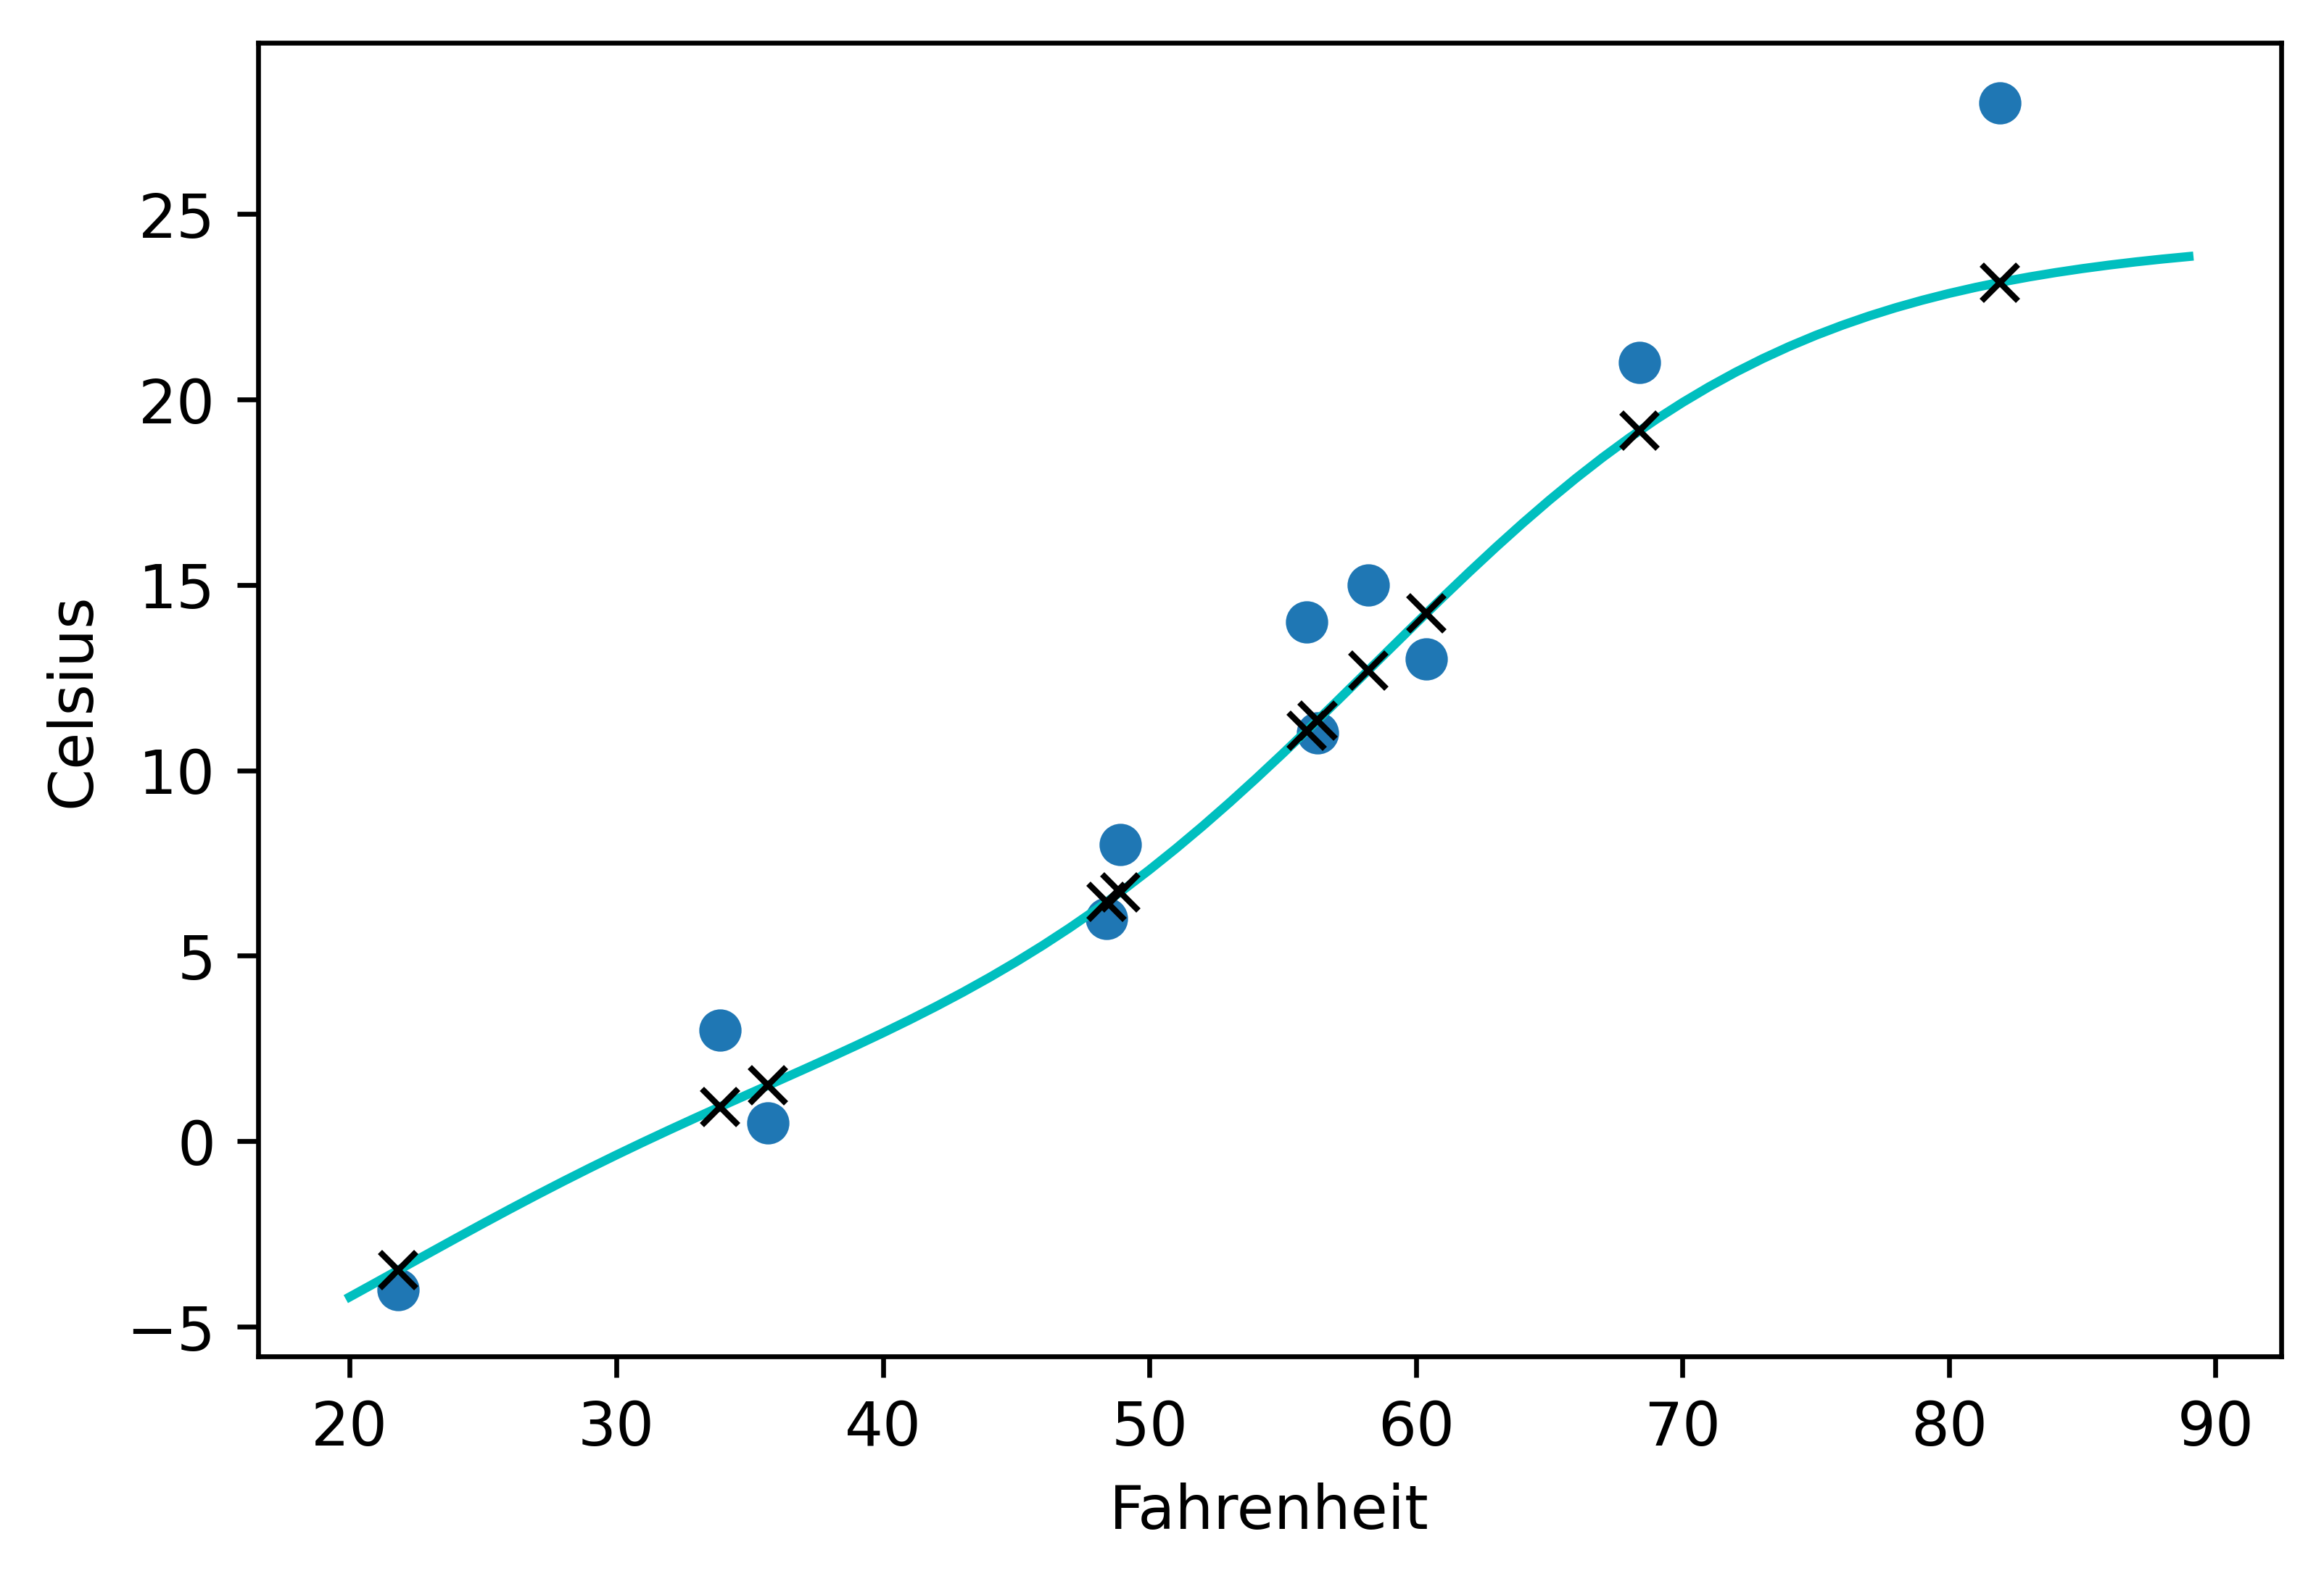

In [28]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


In [29]:
wine_path = "git_rep/data/p1ch4/tabular-wine/winequality-white.csv"

In [30]:
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";", skiprows=1)

In [31]:
wineq = torch.from_numpy(wineq_numpy)

In [32]:
X = wineq[:,:-1]
y = wineq[:,-1]

In [33]:
X.shape, y.shape

(torch.Size([4898, 11]), torch.Size([4898]))

In [37]:
n_samples = X.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

In [38]:
X_train = X[train_indices]
y_train = y[train_indices]

X_val = X[val_indices]
y_val = y[val_indices]

In [50]:
wine_model = torch.nn.Sequential(OrderedDict([
    ('hidden_linear',nn.Linear(11,32)),
    ('hidden_activation', nn.ReLU()),
    ('output_linear', nn.Linear(32,1))
]))

In [51]:
wine_model

Sequential(
  (hidden_linear): Linear(in_features=11, out_features=32, bias=True)
  (hidden_activation): ReLU()
  (output_linear): Linear(in_features=32, out_features=1, bias=True)
)

In [52]:
optimizer = optim.SGD(wine_model.parameters(), lr=1e-3)

In [44]:
y_train = y_train.unsqueeze(1)
y_val = y_val.unsqueeze(1)

In [53]:
import time
start = time.time()
training_loop(n_epochs=5000,
             optimizer= optimizer,
             model= wine_model,
             loss_fn= nn.MSELoss(),
             t_u_train= X_train,
             t_u_val= X_val,
             t_c_train= y_train,
             t_c_val= y_val)
end = time.time()

Epoch 1 , Training Loss 110.7216, Validation Loss 109.7286
Epoch 1000 , Training Loss 1.5418, Validation Loss 1.5730
Epoch 2000 , Training Loss 0.7896, Validation Loss 0.8315
Epoch 3000 , Training Loss 0.7757, Validation Loss 0.8189
Epoch 4000 , Training Loss 0.7752, Validation Loss 0.8184
Epoch 5000 , Training Loss 0.7750, Validation Loss 0.8176


In [55]:
print("Model Took {:.2f} seconds to run.".format(end - start))

Model Took 5.35 seconds to run.
